## 4/24/18 

Played around with analysis based on Orazem paper. See below lmf stuff for detailed walkthrough

In [2]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
%matplotlib inline



importdata = np.genfromtxt('IS400.csv',delimiter=',');  #read in data that i output from matlab. input format has each
                                                        #of the 16 Temperature data sets stacked vertically. 
npoints = 101; #each T has 101 points
IS400 = np.zeros((16,npoints,5)) #Initialize new 3d array to hold data. note: first index is what we would traditionally 
                            #think of as the last index. it makes sense though when you think hierarchically,
                            #i.e. main list has 16 elements each of which has 101 smaller elements containing 5 elemnts. 
for i in range(0,16):
    IS400[i,:,:]=importdata[(npoints*i):(npoints*(i+1)) , :] #slice the data into subarrays  
    
## Function definitions

def Zr(T): #pulls out Z' in units of kOhm*cm^{2} (these are the standard units of impedance). Note that as is, the data is already in units of kOhm
    return IS400[T,:,3]*4e-2
def Zi(T): #pulls out Z'' in units of kOhm*cm^{2}
    return IS400[T,:,4]*4e-2
def w(T): #pulls out omega
    return IS400[T,:,0]



  
    


[0, 1, 0, 1]

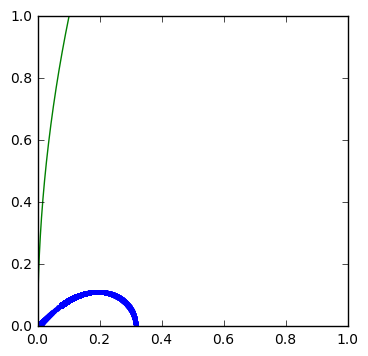

In [3]:
## Fake data for testing
R_act3=.1
wk_act3 = 10
R_act2=10
wk_act2 = .1
#noise= 0.01
wt = np.concatenate((np.linspace(.01,100,10000),np.linspace(101,1e4,1000)))
Zr3 = np.real(np.sqrt(R_act3/(1+(1j*wt/wk_act3))))
Zi3 = np.imag(np.sqrt(R_act3/(1+(1j*wt/wk_act3))))
Zr2 = np.real((0/3)+R_act2/(1+1j*wt/wk_act2))
Zi2 = np.imag((0/3)+R_act2/(1+1j*wt/wk_act2))
#Zr2 = np.sqrt(R_act/(1+(w/wk_act)**2))#+noise*np.random.random(w.size)
#Zi2 = -np.sqrt(R_act*w/(wk_act*(1+(w/wk_act)**2)))#+noise*np.random.random(w.size)
fig,ax= plt.subplots(1,1)
ax.plot(Zr3,-Zi3,'.',Zr2,-Zi2)
ax.set_aspect('equal')
ax.axis([0,1, 0,1])


In [4]:
def circuit_model(w,Rs,Rc,C,n):
    return Rs+(Rc/(1+((1j*w)**n)*C*Rc))

def circuit_resid(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Rs = parvals['Rs']
    Rc = parvals['Rc']
    C = parvals['C']
    n = parvals['n']
    model_real= np.real(circuit_model(w,Rs,Rc,C,n))#np.real(Rs+(Rc/(1+((1j*w)**n)*C*Rc)))
    model_im= np.imag(circuit_model(w,Rs,Rc,C,n))
    #model1 = np.sqrt(R/(1+(w/wk)**2))
    #model2 = -np.sqrt(R*w/(wk*(1+(w/wk)**2)))
    resid1 = model_real-Zr
    resid2 = model_im-Zi
    return np.concatenate((resid1,resid2))

In [5]:
params = lmf.Parameters()  #add parameters with guesses
params.add('Rs',value = 0.1, min = 0)
params.add('Rc',value = 1, min = 0)
params.add('C',value = 1e-5, min = 0)
params.add('n',value = 1, min = 0)


fit = lmf.minimize(circuit_resid,params,args = (w(12)[32:],Zr(12)[32:],Zi(12)[32:]))
Rsfit = fit.params['Rs'].value
Rcfit = fit.params['Rc'].value
Cfit = fit.params['C'].value
nfit = fit.params['n'].value
fit.params

Parameters([('Rs',
             <Parameter 'Rs', value=0.0024024859631750495 +/- 0.000155, bounds=[0:inf]>),
            ('Rc',
             <Parameter 'Rc', value=0.2668468639471071 +/- 0.000306, bounds=[0:inf]>),
            ('C',
             <Parameter 'C', value=0.00012070406170971992 +/- 1.48e-06, bounds=[0:inf]>),
            ('n',
             <Parameter 'n', value=0.93564210842157469 +/- 0.00115, bounds=[0:inf]>)])

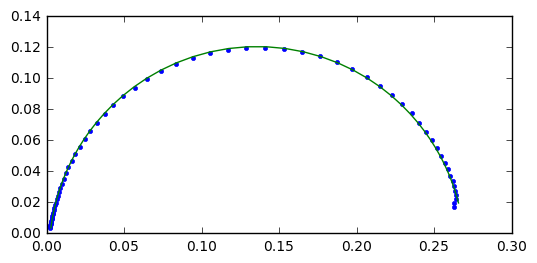

In [6]:
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(np.real(Rsfit+(Rcfit/(1+((1j*w(12)[32:])**nfit)*Cfit*Rcfit))),-np.imag(Rsfit+(Rcfit/(1+((1j*w(12)[32:])**nfit)*Cfit*Rcfit))))
ax.set_aspect('equal')

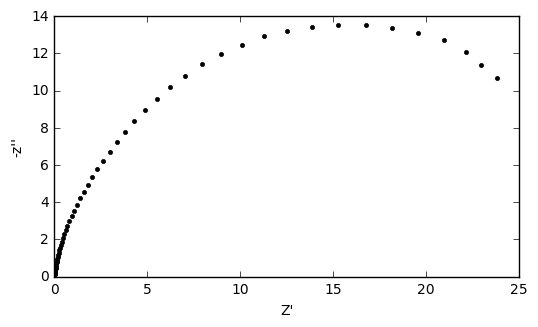

In [7]:
#Just looking at the low T data
fig, ax = plt.subplots(1,1)
ax.plot(Zr(4)[-96:],-Zi(4)[-96:],'k.')
ax.set_aspect('equal')
ax.set_xlabel("Z'")
ax.set_ylabel("-z''")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);


In [8]:
params = lmf.Parameters()  #add parameters with guesses
params.add('Rs',value = 5, min = 0, max = 50)
params.add('Rc',value = 1000, min = 0)
params.add('C',value = 1e-5, min = 0, max = 1e-4)
params.add('n',value = 1, min = .8, max = 1.2)


fit = lmf.minimize(circuit_resid,params,args = (w(4)[-96:],Zr(4)[-96:],Zi(4)[-96:]))
Rsfit = fit.params['Rs'].value
Rcfit = fit.params['Rc'].value
Cfit = fit.params['C'].value
nfit = fit.params['n'].value
fit.params

Parameters([('Rs',
             <Parameter 'Rs', value=0.10830683164209931 +/- 0.0241, bounds=[0:50]>),
            ('Rc',
             <Parameter 'Rc', value=29.703344448098854 +/- 0.171, bounds=[0:inf]>),
            ('C',
             <Parameter 'C', value=9.9999999437628187e-05 +/- 2.34e-06, bounds=[0:0.0001]>),
            ('n',
             <Parameter 'n', value=0.94056053995609235 +/- 0.00359, bounds=[0.8:1.2]>)])

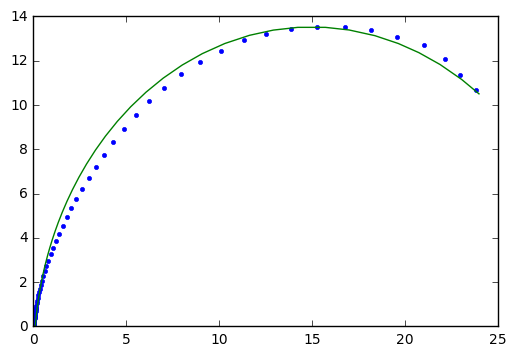

In [9]:
fig,ax = plt.subplots(1,1)
ax.plot(Zr(4)[-96:],-Zi(4)[-96:],'.')
ax.plot(np.real(Rsfit+(Rcfit/(1+((1j*w(4)[-96:])**nfit)*Cfit*Rcfit))),-np.imag(Rsfit+(Rcfit/(1+((1j*w(4)[-96:])**nfit)*Cfit*Rcfit))))
#ax.set_aspect('equal')

# Analysis Notes#


According to Orazem, et al [(10.1149/1.2168377)](http://jes.ecsdl.org/content/153/4/B129.abstract), we can use graphical analysis to make a qualitative and quantitative assessment of the physical processes revealed by impedance spectrra. Through consideration of the Nyquist plot and analysis of the real and imaginary components of the impedance $Z$ with respect to frequency $\omega$, we can characterize both the characteristic frequencies, CPE coefficient $Q$, and CPE exponent $\alpha$. We can then verify these data and run physical analysis on the processes that are represented by these parameters. 

So, let's try the following proposed procedure:

1) **Inspect Nyquist plot**
    We want to see if there are physically distinct processes discernable in the complex plane and roughly determine if a CPE 
    is present
   
2) **Look at Im(Z) vs. $\omega$**
    Peaks occur at characteristic frequencies, and on either side of the peak, the slope of the line should give an estimate 
    of $\alpha$. Once $\alpha$ is obtained, we should be able to estimate $Q$.
    
3) **Look at Re(Z) vs. $\omega$**
    The high frequency asymptote should allow an estimate for the series Ohmic resistance, $R_{s}$.
    
4) **Fit Nyquist Plots**
    Using parameters obtained from steps 2 and 3, see if we can generate a decent fit to the Nyquist plot.
    
    
Let's demonstrate this technique for a sample curve, say the 13th entry in the IS data array.
    

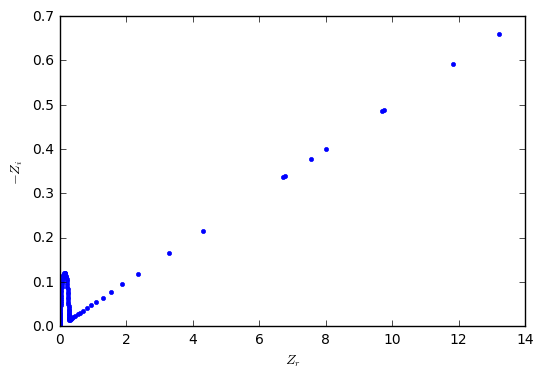

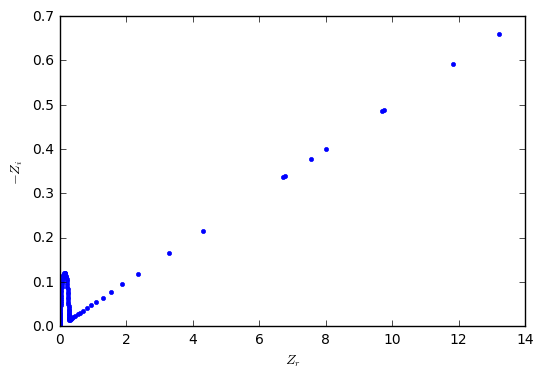

In [10]:
# Nyquist plot for the 13th curve.

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[-96:],-Zi(12)[-96:],'.')
ax.set_xlabel("$Z_{r}$")
ax.set_ylabel("$-Z_{i}$")
# ax.axis([0,8, 0,8])

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[-96:],-Zi(12)[-96:],'.')
ax.set_xlabel("$Z_{r}$")
ax.set_ylabel("$-Z_{i}$")
# ax.axis([0,100, 0,8])


Ok, so the first plot looks like it's a depressed semicircle, which means there's probably a CPE involved. It doesn't look like there are too many other obvious processes (other than the straight line at low frequency), though the presence of a CPE suggests that there may be a smooth continuum of processes occuring. Now, let's look at $Re(Z) vs. \omega$

0.00328052


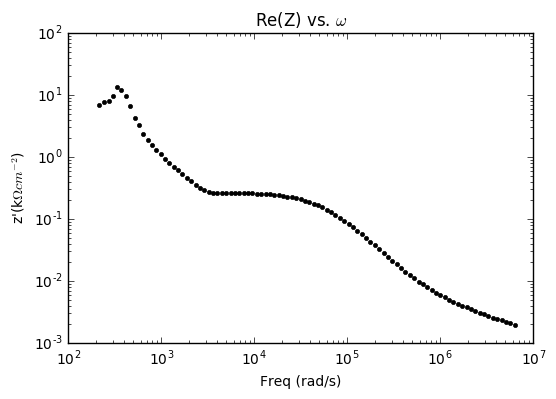

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],Zr(12)[-96:],'k.')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("z'(k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,650]);

print(Zr(12)[-10])

ReEst = Zr(12)[-10]

There appear to be 2 different asymptotes. The highest frequency asymptote is levels out at a very low impedance (of order $5 \times 10^{-2} \Omega$), whereas the mid frequency plateau levels out around $7 \Omega$. We should correlate this data back to the Nyquist plot. But first, check $Im(Z) vs. \omega$. 

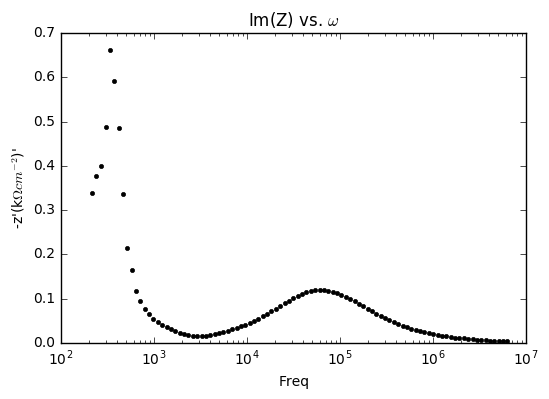

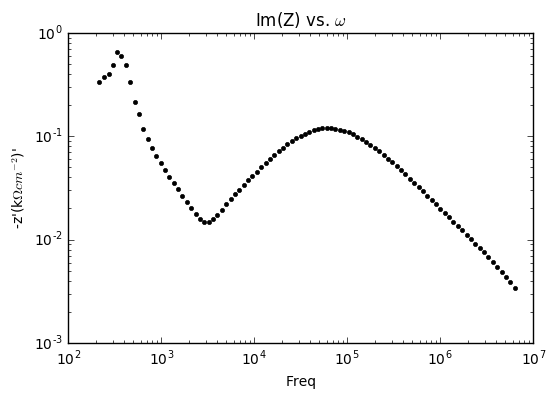

In [12]:
#Bode plot for imaginary part

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(-Zi(12)[-96:]),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{-2}$)'")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(-Zi(12)[-96:]),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{-2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

So from the peak we see that the start of the first plateau in $Re(Z) vs. \omega$ corresponds to the inflection point in $Im(Z) vs. \omega$. The peak in $Im(Z) vs. \omega$ indicating a characterisitic frequency corresponds to the point of max slope after the first plateau in $Re(Z) vs. \omega$.

Before we dive too far into that, let's extract the slope on either side of the curve that corresponds to $\alpha$. Using $\alpha$, we can obtain $Q_{eff}$. Try using the gradient to extract the peak position, and then fitting lines on either side of that position.


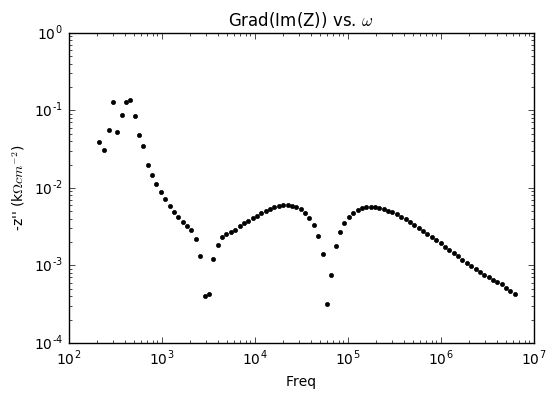

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(np.gradient(-Zi(12)[-96:])),'k.')
# ax.plot(w(12)[peak],abs(np.gradient(-Zi(12)[peak])),'r.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'' (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Grad(Im(Z)) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

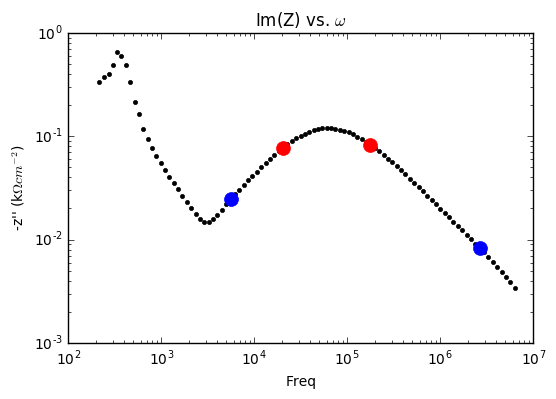

In [14]:
# locate all the important points for the linear fit

boundMin = np.argmax(w(12) > 3e3) + 5
boundMax = -1 - 8
peakRange = np.argmax(abs(Zi(12)[boundMin:boundMax]))
peak = peakRange + boundMin

peak1 = peak - 10
peak2 = peak + 10

# print(boundMin)
# print(boundMax)
# print(peak)
# print(abs(-Zi(12)[peak]))
# print(Zi(12).shape)
# print(w(12)[peak])
# print(w(12)[boundMin:boundMax])
# print(abs(Zi(12)[boundMin:boundMax]))
# print(np.argmax(abs(Zi(12)[boundMin:boundMax])))

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs((-Zi(12)[-96:])),'k.')
ax.plot(w(12)[peak1],abs((-Zi(12)[peak1])),'r.', markersize = 20)
ax.plot(w(12)[peak2],abs((-Zi(12)[peak2])),'r.', markersize = 20)
ax.plot(w(12)[boundMin],abs((-Zi(12)[boundMin])),'b.', markersize = 20)
ax.plot(w(12)[boundMax],abs((-Zi(12)[boundMax])),'b.', markersize = 20)
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'' (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")


0.900115173316 -11.447047472
-0.8612230806 7.97405427793
0.880669126958


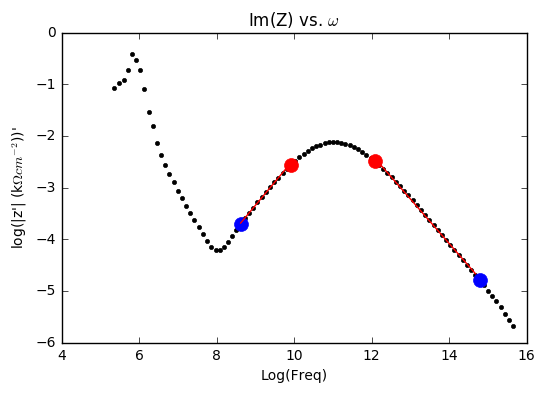

In [15]:
# run linear regressions on either side of peak to obtain \alpha

x1 = np.vstack( [np.log(w(12)[boundMin:peak1]), np.ones(len(w(12)[boundMin:peak1]))]).T
y1 = np.log(abs(Zi(12)[boundMin:peak1]))

m1,c1 = np.linalg.lstsq(x1,y1)[0]
print(m1,c1)

x2 = np.vstack( [np.log(w(12)[peak2:boundMax]), np.ones(len(w(12)[peak2:boundMax]))]).T
y2 = np.log(abs(Zi(12)[peak2:boundMax]))

m2,c2 = np.linalg.lstsq(x2,y2)[0]
print(m2,c2)



fig, ax = plt.subplots(1,1)
ax.plot(np.log(w(12)[-96:]),np.log(abs((-Zi(12)[-96:]))),'k.')
ax.plot(np.log(w(12)[peak1]),np.log(abs((-Zi(12)[peak1]))),'r.', markersize = 20)
ax.plot(np.log(w(12)[peak2]),np.log(abs((-Zi(12)[peak2]))),'r.', markersize = 20)
ax.plot(np.log(w(12)[boundMin]),np.log(abs((-Zi(12)[boundMin]))),'b.', markersize = 20)
ax.plot(np.log(w(12)[boundMax]),np.log(abs((-Zi(12)[boundMax]))),'b.', markersize = 20)

ax.plot(np.log(w(12)[boundMin:peak1]), m1*np.log(w(12)[boundMin:peak1]) + c1, 'r')

ax.plot(np.log(w(12)[peak2:boundMax]), m2*np.log(w(12)[peak2:boundMax]) + c2, 'r')

# ax.set_aspect('equal')
ax.set_xlabel("Log(Freq)")
ax.set_ylabel("log(|z'| (k$\Omega cm^{-2}$))'")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")

alpha = np.array([abs(m1),abs(m2)])
alpha = np.mean(alpha)
print(alpha)



Ok, so now we have an estimate for $\alpha$. Excellent.

Now let's solve for Q by using the Orazem paper cited above. We need to solve $Q_{eff} = sin(\frac{\alpha \pi}{2})\frac{-1}{Z_{j}(\omega)(2 \pi \omega)^{\alpha}}$. We then plot this vs. frequency. $Q_{eff}$ should assume it's apparent value above the characteristic frequency given by the peak in the $Im(Z) vs. \omega$ plot. 

84 0.000257600679502


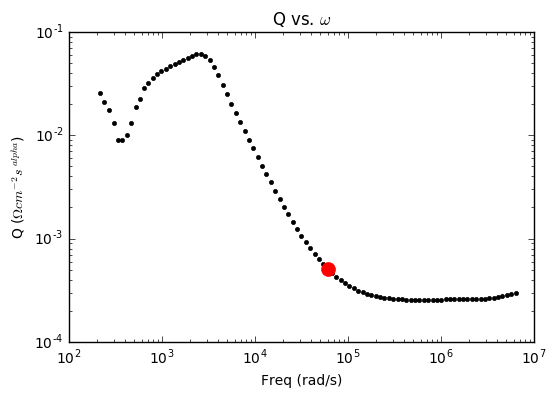

In [16]:
#calculate and estiamte Qeff

Qarray = np.sin((alpha*np.pi)/2)*(-1/(Zi(12)*w(12)**(alpha)))


fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],Qarray[-96:],'k.')
ax.plot(w(12)[peak],Qarray[peak],'r.', markersize = 20)

# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("Q ($\Omega cm^{-2} s^{\ alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
ax.set_title("Q vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);


wEff = np.argmax(w(12) > 1e6)
Qeff = Qarray[wEff]
print(wEff,Qeff)


In [17]:
# Estimate R_{f} from the resonance peak and the estimate of Q

RfEst = (1/w(12)[peak])/Qeff
print(RfEst)
print( (w(12)[peak])**(-alpha))

0.0647762742193
6.20129750603e-05


So now we have estimated $R_{e}$, $\alpha$, and $Q$, $R_{f}$. For completeness, let's take a peek at the magnitude and phase of Z. 

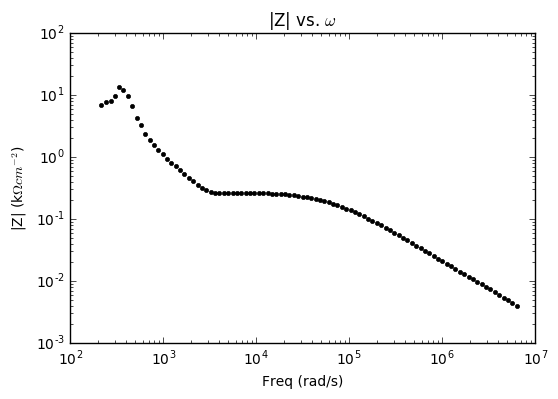

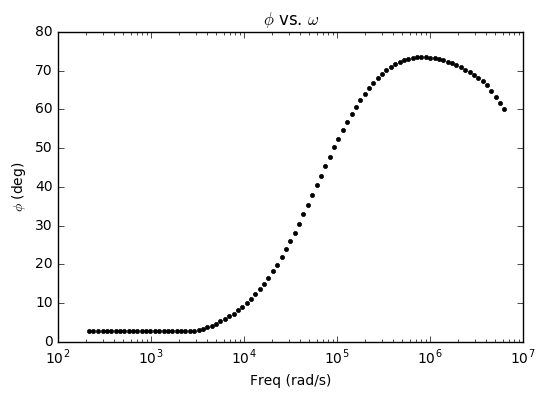

In [18]:

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],np.sqrt(np.square(Zr(12)[-96:]) + np.square(Zi(12)[-96:])),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);


fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],-np.arctan((Zi(12)[-96:])/(Zr(12)[-96:]))*(180/np.pi),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("$\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

From the phase angle plot, we see that at low frequency, the 2 components impedance components $R_{s}$ and the $RC/RQ$ network are in phase. As a result, the impedance is completely real at low frequency. 

The plateau in the middle of the $|Z| vs. \omega$ plot comes from the fact that the $RC/RQ$ component starts becoming important $\sim 3 \times 10^{3}$ rad/s. This continues all the way until it dominates the impedance, and the $RC/RQ$ component is maximally out of phase with $Re(Z)$. However, because we have a CPE, the max phase angle achieved is less than 90. 

Now, let's try and fit the Nyquist plot using our parameter guesses extracted graphically above.

In [19]:
# set up the objective function

def circuitModelQ(w,Re,Rf,Q,a):
    return Re+(Rf/(1+((1j*w)**a)*Q*Rf))

def circuitResidQ(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Re = parvals['Re']
    Rf = parvals['Rf']
    Q = parvals['Q']
    a = parvals['a']
    ZrHat = np.real(circuitModelQ(w,Re,Rf,Q,a))
    ZiHat = np.imag(circuitModelQ(w,Re,Rf,Q,a))
    #model1 = np.sqrt(R/(1+(w/wk)**2))
    #model2 = -np.sqrt(R*w/(wk*(1+(w/wk)**2)))
    resid1 = ZrHat-Zr
    resid2 = ZiHat-Zi
    return np.concatenate((resid1,resid2))

# # set up an alternative objective function

# def circuitModelQ2(w,Q,n):
#     return 1/(((1j*w)**n)*Q)

# def circuitResidQ2(params,w,Zr,Zi):
#     parvals = params.valuesdict()
#     Q = parvals['Q']
#     n = parvals['n']
#     ZrHat2 = np.real(circuitModelQ2(w,Q,n))#np.real(Rs+(Rc/(1+((1j*w)**n)*C*Rc)))
#     ZiHat2 = np.imag(circuitModelQ2(w,Q,n))
#     #model1 = np.sqrt(R/(1+(w/wk)**2))
#     #model2 = -np.sqrt(R*w/(wk*(1+(w/wk)**2)))
#     resid1b = ZrHat2-Zr
#     resid2b = ZiHat2-Zi
#     return np.concatenate((resid1b,resid2b))



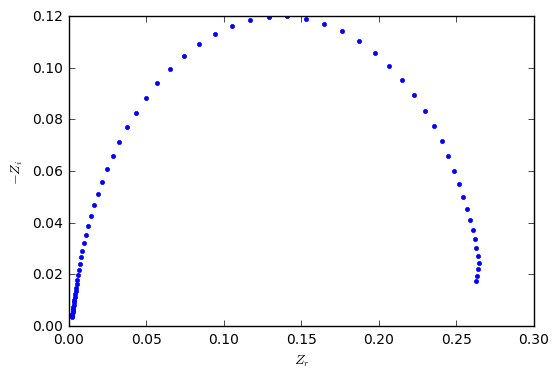

In [20]:
# figure out the range over which the data should be fit

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.set_xlabel("$Z_{r}$")
ax.set_ylabel("$-Z_{i}$")
# ax.axis([0,8, 0,8])

In [21]:
print(Qeff, alpha)

0.000257600679502 0.880669126958


Parameters([('Re', <Parameter 'Re', value=2.9517695898650942e-07 +/- 0.000455, bounds=[0:5]>), ('Rf', <Parameter 'Rf', value=0.27387600258548805 +/- 0.000934, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00017611262331024109 +/- 6.27e-06, bounds=[0:0.001]>), ('a', <Parameter 'a', value=0.89999999999383284 +/- 0.00304, bounds=[0.6:0.9]>)])


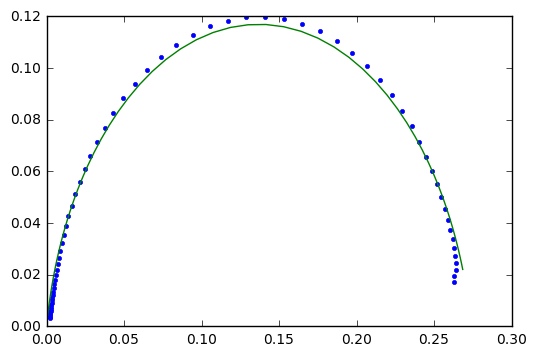

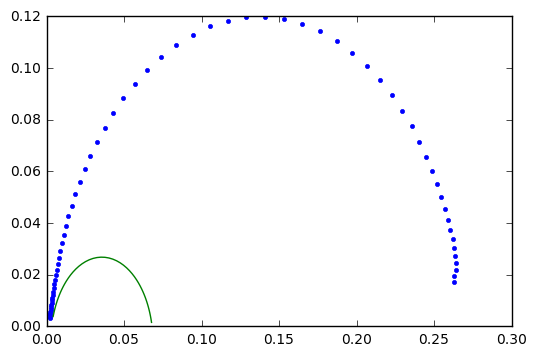

In [22]:
# run the fit for the first objective function

params = lmf.Parameters()  #add parameters with guesses
params.add('Re',value = ReEst, min = 0, max = 5)
params.add('Rf',value = RfEst, min = 0, max = 100)
params.add('Q',value = Qeff, min = 0, max = 1e-3)
params.add('a',value = alpha, min = .6, max = 0.90)


fit = lmf.minimize(circuitResidQ,params,args = (w(12)[32:],Zr(12)[32:],Zi(12)[32:]))
Refit = fit.params['Re'].value
Rffit = fit.params['Rf'].value
Qfit = fit.params['Q'].value
afit = fit.params['a'].value
fit.params

print(fit.params)

# plot the resulting fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(np.real(Refit+(Rffit/(1+((1j*w(12)[32:])**afit)*Qfit*Rffit))),-np.imag(Refit+(Rffit/(1+((1j*w(12)[32:])**afit)*Qfit*Rffit))))
# ax.set_aspect('equal')


# for comparison, plot the values extracted above
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(np.real(ReEst+(RfEst/(1+((1j*w(12)[32:])**alpha)*Qeff*RfEst))),-np.imag(ReEst+(RfEst/(1+((1j*w(12)[32:])**alpha)*Qeff*RfEst))))
# ax.set_aspect('equal')

So, it seems like the graphical extraction method is *somehwat* close to what shakes out of the Nyquist plot, but it's not quite there.

Specifically, the $R_{s}$ extraction is good, but both the $\alpha$ and resulting $Q_{eff}$ values obtained by the fit are off. In the case of $\alpha$, we are off by a little over 10%, and resulting in about an order of magnitude discrepancy between the two ways of calculating $Q_{eff}$.

This could be from numerous sources:
1) The fits to the $Im(Z) vs. \omega$ could need to be fixed. Adjusting the bounds on the linear fits changes the slope dramatically. We'll need to explore that.

2) Do I have the right model? Does $Q = RC$, or $Q = C$? If the former, we aren't that far off. If the latter, we'll need a better way

All in all, I don't find this too troubling--the graphical way simply estimates $Q$ and $\alpha$. The regression should result in the proper values. The first part was just trying to obtain a guess for these things. Perhaps most importantly, by looking at the phase angle data, we can tell there is a high frequency CPE. 

So maybe after futzing a bit with the fits to estimtae $\alpha$ and double-checking the model, let's see what we can do about this resistivity thing.

# Update , 4/25/2018#

After fiddling with the fits a bit, I was able to reduce the discrepancy between the linear estimation of $\alpha$ and $\alpha$ obtained via NLLS fit to $\sim 5\%$, resulting in a $2\times$ difference between the estimated and fit $Q_{eff}$ parameters. Not bad.

So, it seems like the CPE terms can be estimated by the graphical methods above, but more accurate values are obtained via NLLS. Fair enough!

Now, let's see if we can relate the parameters extracted via this analysis to transport physics within the device. 

We will attempt to link these quantities by a method first outlined by Hirschorn and Orazem [(10.1149/1.3499565)](http://jes.ecsdl.org/content/158/12/C424.abstract?utm_source=TrendMD&utm_medium=cpc&utm_campaign=Journal_of_The_Electrochemical_Society_TrendMD_0) in wich CPE behavior is posited to be the result of a **power law distrinution of resisitivies** throughout the film thickness. This theory may be applicable in our case because it explicitly addresses variations in resistivity and transport along the axis normal to the electrode surface, and we know that transport in QD films is highly local.

It will be interesting to see if this matches with the intuition we have about transport in the ZnO layer vs. transport the in the PbS layer. In particular, we expect the ZnO part to have a lower resistivity $\rho$ than the PbS layer. Is this seen in the data? Does this imply that charge transfer at the junction is the rate limiting step? Does the CPE result from loss due to surface states at this interface?

To formalize this analysis, we will certainly need the following information:

1) film thickness

2) total stack dielectric constant

For now, let's simply assume a uniform PbS layer of thickness $\delta = 90$ nm or so and $\varepsilon = 12\varepsilon_{0}$. We can ammend this data later.

To complete this analysis, we will do the following:

1) calculate the resistivity at one boundary $\rho_{\delta}$ using the following equation from the Hirschorn paper:
    $Q_{eff} = \frac{(\epsilon\varepsilon_{0})^{\alpha}}{g \delta \rho_{\delta}^{(1-\alpha)}}$. Here, $\delta$ is the film 
    thickness, and $g = 1 + 2.88(1-\alpha)^{2.375}$ as determined numerically by Hirschorn, et. al.
    
2) See if we can esimate the resisitivy at the other boundary $\rho_{0}$, by considering the DC limit of the impedance and the following equation: $Z(\omega = 0) = \frac{(\rho_{0} \varepsilon \varepsilon_{0})^{\alpha}}{Q_{eff}}$

3) Plug these values into the following proposed power law distribution:
    $\frac{\rho}{\rho_{\delta}} = (\frac{\rho_{\delta}}{\rho_{0}} + (1 - \frac{\rho_{\delta}}{\rho_0}) \xi^{\gamma})^{-1}$
    Here, $\xi = \frac{x}{\delta}$ is a dimensionless position parameter, and $\gamma$ is defined in terms of $\alpha$: $\alpha = \frac{1-\gamma}{\gamma}$.
    
The end goal of this is to get some idea of how all of this hangs together. From there, we can see how far we want to pursue these ideas. 


Let's start by calculating $\rho_{\delta}$. Let $\varepsilon = 8.854\times10^{-12}$ F/m, and use $\delta = 200 nm = 2\times10^{-7} m$. 
   

In [23]:
# calculate \rho_{\delta} in units of ohm*cm^{-2}

epsilon0 = 8.854e-14
epsilon = 12
gFac = 1 + (2.88*(1-nfit)**(2.375))
delta = 300e-7

rhoD1 = ( ((epsilon*epsilon0)**(afit))/(gFac * delta * Qfit*1e-3))**(1/(1-afit))
rhoD2 = ( ((epsilon*epsilon0)**(alpha))/(gFac * delta * Qeff*1e-3))**(1/(1-alpha))

print(rhoD1, 1/(1-afit))
print(rhoD2, 1/(1-alpha))




98279.7993579 9.99999999938
54872.7557504 8.3800610396


After wrangling around with the units for quite some time, we get $\rho_{\delta} \approx 4.7 \times 10^{3} \Omega cm$. Not bad! Or, at least, that seems reasonable. 

Now we need to calculate $\rho_{0}$. We'll need to think about this one for a second.

[ 1398.8080407]
[ 92106185.94502144] [  1.15828944e+08]


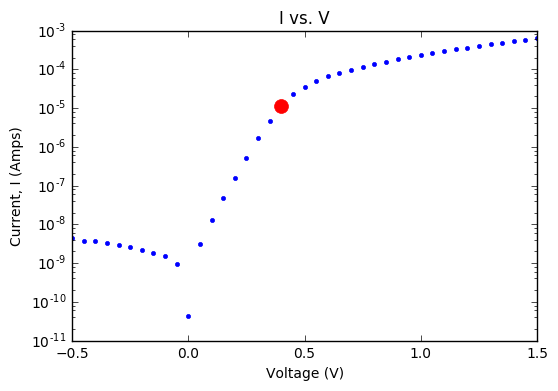

In [31]:
# import and plot IV  or JV data. extract the current at the point of interest. calculate the resulting impedance.
# then, calculate $\rho_{0}$

ivData = np.genfromtxt('dev1_fullrange_300K.txt')

# print(ivData)
# print(ivData.shape)
# print(ivData[0:41])


# initialize new array, with first column for voltage data and second column for current data
iv = np.zeros((2,41))
jv = np.zeros((2,41))

iv[0,:] = ivData[0:41]
iv[1,:] = ivData[41:]

# define an array for current density
jv[0,:] = iv[0,:]
jv[1,:] = (1e3*iv[1,:])/4e-2

# print(jv[0,:])

# calculate the DC impedance at V = 400mV, z0, in units of Ohm cm^{-2}
poi = np.where(iv[0,:] == 0.4)[0]
i0 = iv[1,poi]
z0 = ((iv[0,poi]/iv[1,poi])*4e-2)

print(z0)

# plot the IV data and label the point of interest
fig,ax = plt.subplots(1,1)
ax.plot(iv[0,:],abs(iv[1,:]),'.')
ax.plot(iv[0,poi],abs(iv[1,poi]),'r.',markersize = 20)
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current, I (Amps)")
ax.set_yscale("log") 
ax.set_title("I vs. V")


rho01 = ( ((Qfit*1e-3)*z0)**(1/afit))/(epsilon*epsilon0)
rho02 = ( ((Qeff*1e-3)*z0)**(1/alpha))/(epsilon*epsilon0)

print(rho01, rho02)



Ok so the model parameters with re-updated units yield sort of crappy fits. Hm.

It seems like we might need to re-evaluate the frequency range over which this model operates. Let's take our calculated expressions for $\rho_{\delta}$ and $\rho_{0}$ and generate the limiting frequencies $\omega_{\delta}$ and $\omega_{0}$ to determine the frequency range in which the CPE is operating.

From the paper, we know $\omega_{0} = (\rho_{0}\varepsilon \varepsilon_{0})^{-1}$, and likewise $\omega_{\delta} = (\rho_{\delta}\varepsilon \varepsilon_{\delta})^{-1}$.


[ 10218.57736837] 9576679.9824
41 0


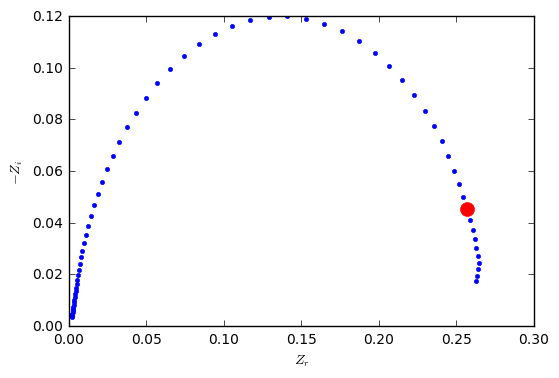

In [34]:
omega0 = 1/(rho01*epsilon*epsilon0)
omegaD = 1/(rhoD1*epsilon*epsilon0)

print(omega0,omegaD)


# re-plot the Nyquist plot highlighting available frequencies

w0 = np.argmax(w(12)>omega0)
wD = np.argmax(w(12)>omegaD)
print(w0, wD)

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(Zr(12)[w0],-Zi(12)[w0],'r.',markersize = 20)
ax.set_xlabel("$Z_{r}$")
ax.set_ylabel("$-Z_{i}$")
# ax.axis([0,8, 0,8])

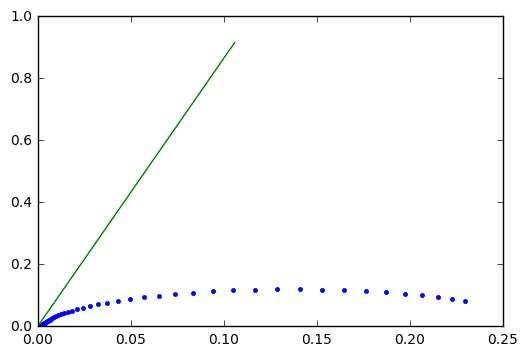

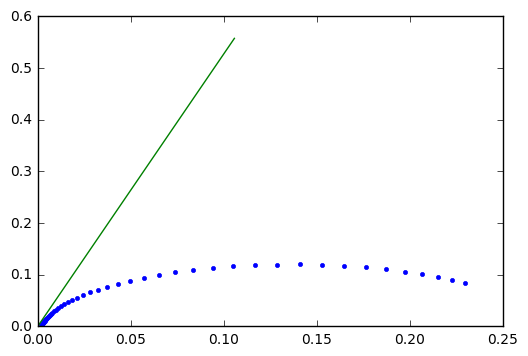

In [173]:
# re-try fit from this point onward...?

params = lmf.Parameters()  #add parameters with guesses
params.add('Q',value = Qeff, min = 0, max = 1e-4)
params.add('n',value = alpha, min = .5, max = .93)


fit = lmf.minimize(circuitResidQ2,params,args = (w(12)[48:],Zr(12)[48:],Zi(12)[48:]))
Qfit = fit.params['Q'].value
nfit = fit.params['n'].value
fit.params


fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[48:],-Zi(12)[48:],'.')
ax.plot(np.real((1/(((1j*w(12)[48:])**nfit)*Qfit))),-np.imag((1/(((1j*w(12)[48:])**nfit)*Qfit))))# ax.set_aspect('equal')


# for comparison, plot the values extracted above
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[48:],-Zi(12)[48:],'.')
ax.plot(np.real((1/(((1j*w(12)[48:])**alpha)*Qeff))),-np.imag((1/(((1j*w(12)[48:])**alpha)*Qeff))))
# ax.set_aspect('equal')